In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pipeline import build_preprocessing_pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from scipy.stats import uniform, randint
from modelos import XGBWithThreshold
from metricas import custom_fbeta

import xgboost as xgb

pd.set_option('display.max_columns', 50)

In [2]:
path = 'data'
df = pd.read_csv(f'{path}/train_test_network.csv')
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_query,dns_qclass,dns_qtype,dns_rcode,dns_AA,dns_RD,dns_RA,dns_rejected,ssl_version,ssl_cipher,ssl_resumed,ssl_established,ssl_subject,ssl_issuer,http_trans_depth,http_method,http_uri,http_version,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,2019-04-02 09:45:58,3.122.49.24,1883,192.168.1.152,52976,tcp,-,80549.530260,1762852,41933215,OTH,0,252181,14911156,2,236,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,bad_TCP_checksum,-,F,0,normal
1,2019-04-02 09:45:58,192.168.1.79,47260,192.168.1.255,15600,udp,-,0.000000,0,0,S0,0,1,63,0,0,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,0,normal
2,2019-04-02 09:45:59,192.168.1.152,1880,192.168.1.152,51782,tcp,-,0.000000,0,0,OTH,0,0,0,0,0,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,bad_TCP_checksum,-,F,0,normal
3,2019-04-02 09:45:59,192.168.1.152,34296,192.168.1.152,10502,tcp,-,0.000000,0,0,OTH,0,0,0,0,0,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,0,normal
4,2019-04-02 09:46:02,192.168.1.152,46608,192.168.1.190,53,udp,dns,0.000549,0,298,SHR,0,0,0,2,354,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,bad_UDP_checksum,-,F,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461038,2019-04-27 04:54:22,192.168.1.32,33108,176.28.50.165,80,tcp,-,0.000000,0,0,S0,0,1,60,0,0,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,xss
461039,2019-04-28 03:49:50,192.168.1.33,37242,34.230.157.88,443,tcp,-,0.000000,0,0,OTH,0,0,0,1,103,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,ransomware
461040,2019-04-28 07:30:03,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,0,108,108064,31,3832,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
461041,2019-04-29 12:20:42,192.168.1.31,60816,104.98.29.100,443,tcp,-,23.190902,32,31,SF,0,8,411,7,395,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,mitm


In [3]:
df.src_ip.value_counts()

src_ip
192.168.1.190     77033
192.168.1.152     67784
192.168.1.30      61637
192.168.1.79      41098
192.168.1.195     36089
                  ...  
255.42.60.52          1
243.111.49.216        1
10.3.191.169          1
74.166.95.98          1
118.164.23.26         1
Name: count, Length: 11536, dtype: int64

# Análise Temporal

Text(0.5, 1.0, 'Histograma de ataques e tráfego normal')

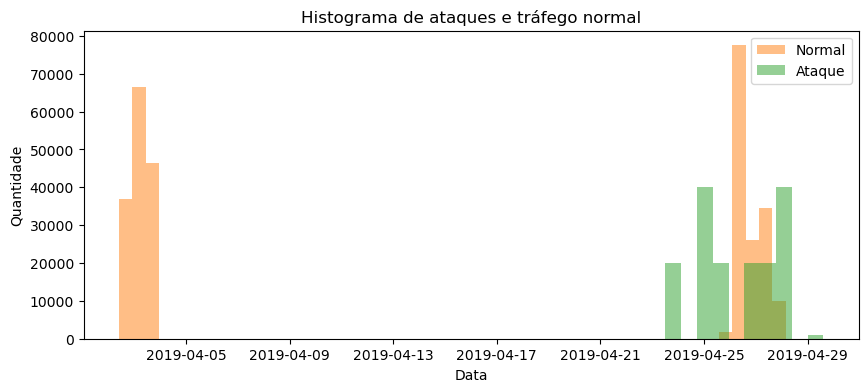

In [4]:
plt.figure(figsize=(10, 4))
plt.hist(df.loc[df.type == 'normal', 'ts'], bins=50, alpha=0.5, label='normal', color='tab:orange');
plt.hist(df.loc[df.label == 1, 'ts'], alpha=0.5, label='ataque', color='tab:green');
plt.legend(['Normal', 'Ataque'])
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.title('Histograma de ataques e tráfego normal')

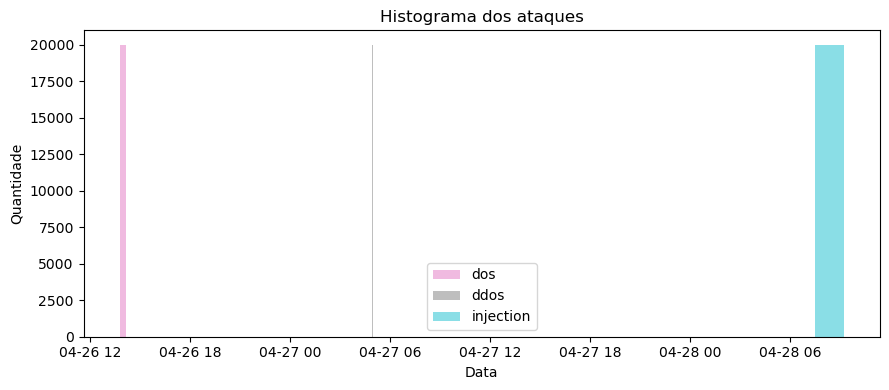

In [5]:
bins = 1
plt.figure(figsize=(9, 4))
#plt.hist(df.loc[df.type == 'scanning', 'ts'], bins=bins, alpha=0.5, label='Ccanning', color='tab:green');
#plt.hist(df.loc[df.type == 'dos', 'ts'], bins=bins, alpha=0.5, label='DoS', color='tab:blue');
#plt.hist(df.loc[df.type == 'ddos', 'ts'], bins=bins, alpha=0.5, label='DDoS', color='tab:red');
#plt.hist(df.loc[df.type == 'mitm', 'ts'], bins=bins, alpha=0.5, label='MitM', color='tab:purple');
#plt.hist(df.loc[df.type == 'injection', 'ts'], bins=bins, alpha=0.5, label='Injection', color='tab:brown');
plt.hist(df.loc[df.type == 'password', 'ts'], bins=bins, alpha=0.5, label='Password', color='tab:pink');
plt.hist(df.loc[df.type == 'xss', 'ts'], bins=bins, alpha=0.5, label='XSS', color='tab:gray');
#plt.hist(df.loc[df.type == 'ransomware', 'ts'], bins=bins, alpha=0.5, label='Ransomware', color='tab:olive');
plt.hist(df.loc[df.type == 'backdoor', 'ts'], bins=bins, alpha=0.5, label='Backdoor', color='tab:cyan');
#plt.legend(['Scanning', 'DoS', 'DDoS', 'MitM', 'Injection', 'Password', 'XSS', 'Ransomware', 'Backdoor'])
plt.legend(['dos', 'ddos', 'injection'])
plt.title('Histograma dos ataques')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.tight_layout()

Conclusão: não faz sentido incluir a variável de tempo na avaliação nem no treinamento, pois

- Variável não representa um padrão real, já que os ataques de cada tipo só acontecem dentro de uma única janela de tempo específica, dando a entender que foi agendado um horário para cada modalidade de ataque, o que não acontece na realidade.
- Além disso, sabendo que essa variável representa um cenário artificial, incluí-la daria lugar a um cenário otimista de avaliação, pois o modelo facilmente aprenderia que dentro daquela janela de tempo sempre acontecem esses ataques. No entanto, essa janela de tempo é artificial e aprender esse padrão não torna o modelo generalizável.

# Volumetrias

In [6]:
df.label.value_counts()

label
0    300000
1    161043
Name: count, dtype: int64

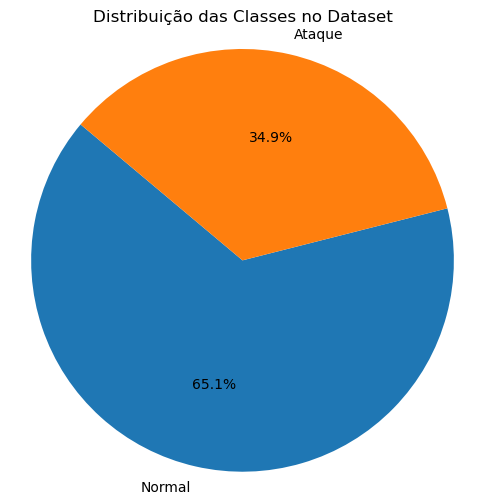

In [7]:
import matplotlib.pyplot as plt

# Dados fornecidos
labels = ['Normal', 'Ataque']
counts = [300000, 161043]

# Criando o gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['tab:blue', 'tab:orange'])
plt.title('Distribuição das Classes no Dataset')
plt.axis('equal')  # Garante que o gráfico seja circular
plt.show()


In [8]:
[s.capitalize() for s in df.type.value_counts().index]

['Normal',
 'Scanning',
 'Dos',
 'Injection',
 'Ddos',
 'Password',
 'Xss',
 'Ransomware',
 'Backdoor',
 'Mitm']

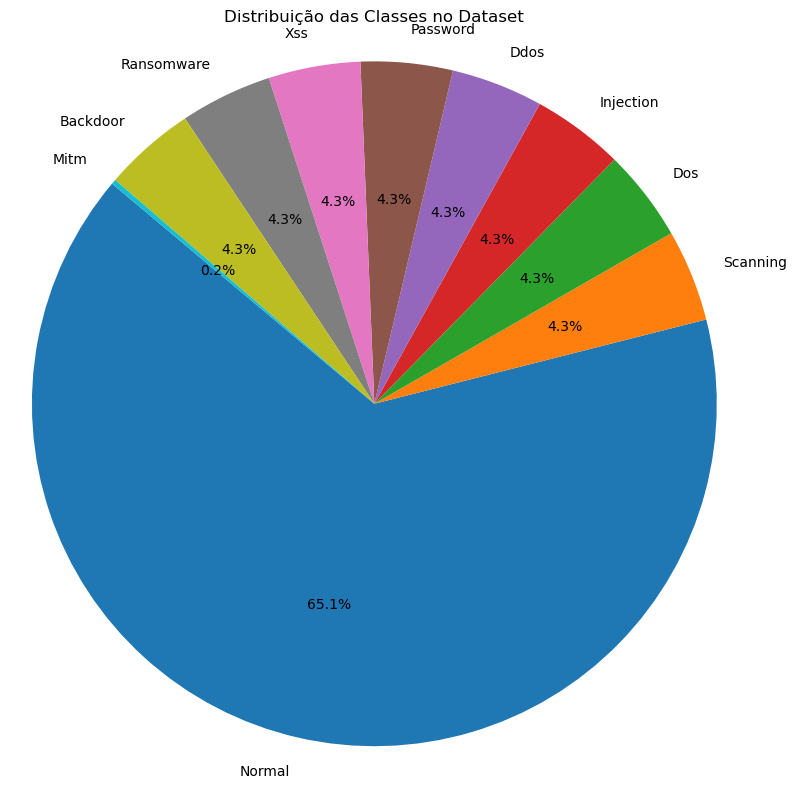

In [9]:
# Dados fornecidos
value_counts = df.type.value_counts()
labels = [s.capitalize() for s in value_counts.index]
counts = value_counts.values

# Criando o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição das Classes no Dataset')
plt.axis('equal')  # Garante que o gráfico seja circular
plt.tight_layout()

# Separação: Dev-Teste

In [10]:
X = df.iloc[:, :-2]
y = df.iloc[:, -2:]

X = X.drop(columns=['src_ip', 'src_port', 'dst_ip', 'dst_port'])

Xdev, Xtest, ydev, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

Xdev = Xdev.reset_index(drop=True)
Xtest = Xtest.reset_index(drop=True)
ydev = ydev.reset_index(drop=True)
ytest = Xtest.reset_index(drop=True)

In [11]:
Xdev.head(5)

,ts,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_query,dns_qclass,dns_qtype,dns_rcode,dns_AA,dns_RD,dns_RA,dns_rejected,ssl_version,ssl_cipher,ssl_resumed,ssl_established,ssl_subject,ssl_issuer,http_trans_depth,http_method,http_uri,http_version,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice
0,2019-04-03 20:00:32,tcp,-,0.000000,0,0,OTH,0,0,0,0,0,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-
1,2019-04-03 01:06:34,udp,-,0.543297,0,48,SHR,0,0,0,1,76,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-
2,2019-04-03 02:15:02,udp,-,0.000000,0,0,S0,0,1,63,0,0,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-
3,2019-04-26 13:49:08,tcp,http,0.011680,155,978,SF,0,5,375,4,1150,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-
4,2019-04-27 03:25:25,udp,dns,0.128667,47,158,SF,0,1,75,1,186,v10.events.data.microsoft.com,1,1,0,F,T,T,F,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-


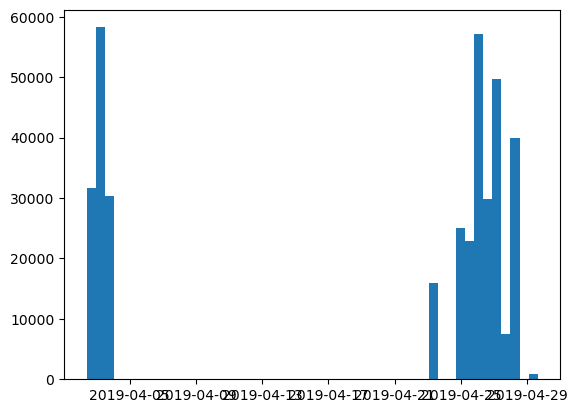

In [12]:
plt.hist(Xdev.ts, bins=50);

In [24]:
counts[counts.dst_ip.str[:3] == '172']

,dst_ip,count
303,172.217.25.131,37
346,172.217.25.142,32
389,172.217.25.138,27
727,172.246.116.7,15
737,172.217.25.162,14
773,172.217.167.74,14
1034,172.217.25.42,10
1266,172.217.25.166,8
1306,172.217.25.35,8
1632,172.217.25.161,7


In [32]:
counts[(counts.src_ip.str[:3] == '169')]

,src_ip,count
370,169.38.98.57,1
1229,169.106.249.40,1
1350,169.18.115.162,1
1432,169.151.122.119,1
1459,169.187.209.22,1
1506,169.146.221.10,1
1576,169.243.24.134,1
2756,169.140.228.18,1
3156,169.248.201.16,1
3204,169.149.50.117,1


In [22]:
counts[(counts.dst_ip.str[:3] != '192') & (counts.dst_ip.str[:3] != '172')]

,dst_ip,count
5,127.0.0.1,20143
7,239.255.255.250,17757
13,176.28.50.165,9315
14,224.0.0.251,6052
17,52.28.231.150,3644
...,...,...
5262,202.4.31.73,1
5263,200.62.191.10,1
5265,85.90.64.164,1
5266,202.3.54.32,1


In [30]:
counts = pd.DataFrame(df.src_ip.value_counts()).reset_index()
counts

,src_ip,count
0,192.168.1.190,77033
1,192.168.1.152,67784
2,192.168.1.30,61637
3,192.168.1.79,41098
4,192.168.1.195,36089
...,...,...
11531,255.42.60.52,1
11532,243.111.49.216,1
11533,10.3.191.169,1
11534,74.166.95.98,1


In [48]:
import ipaddress
ip1 = ipaddress.ip_address('192.168.0.1')
ip2 = ipaddress.ip_address('192.168.0.2')

dff = pd.DataFrame()
x = df.src_ip.apply(ipaddress.ip_address)
dff['x'] = x
dff

,x
0,3.122.49.24
1,192.168.1.79
2,192.168.1.152
3,192.168.1.152
4,192.168.1.152
...,...
461038,192.168.1.32
461039,192.168.1.33
461040,192.168.1.37
461041,192.168.1.31


In [45]:
x == ipaddress.ip_address('3.122.49.24')

0          True
1         False
2         False
3         False
4         False
          ...  
461038    False
461039    False
461040    False
461041    False
461042    False
Name: src_ip, Length: 461043, dtype: bool